In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
from tensorflow import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.client import device_lib
from tf_agents.train.utils import strategy_utils

from matplotlib import font_manager, rc, dates
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

print(tf.__version__)
print(device_lib.list_local_devices())

def reward_co2(co2):
    reward = np.exp(-((co2-900)**2)/(2*350**2))
    return reward


def reward_heat(temp):
    reward = np.exp(-((temp-29)**2)/(2*2**2))
    return reward

## 불러오기 ##
path = os.getcwd()
site_list = sorted(glob(os.path.join(path,"data","sensing_data","*")))
site_list = list(map(os.path.basename,site_list))
print(path)
print(site_list)
site = "솜사탕"
time_mean = "5T"
csv_by_site_det = []


structure = sorted(glob(os.path.join(path,"data","sensing_data",site,'*')))
structure = list(map(os.path.basename,structure))
for j in structure:
        temp_data = dd.read_csv(os.path.join(path,"data","sensing_data",site,j),encoding='cp949').compute()
        temp_data['T/D'] = pd.to_datetime(temp_data['T/D'])
       
        temp_data.set_index('T/D',inplace=True)
        temp_data = temp_data.resample(time_mean,).mean()
        temp_data['site_details'] = j
        csv_by_site_det.append(temp_data)

data = pd.concat(csv_by_site_det)
data.columns = ['index','temp','hum','pm1','pm2.5','pm4','pm10','co2','tvoc','site_details']
data = data[['temp','hum','pm1','pm2.5','pm4','pm10','co2','tvoc','site_details']]
## 라벨링 ##

data['vent'] = 0
data['people'] = 0
data['heat'] = 0


data.loc[data.between_time('12:00:00', '18:00:00',include_end=False).index,['vent']] = 1
data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['people']] = 1
data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['heat']] = 1

#0부터 월요일
data.loc[data[data.index.dayofweek == 5].index,['vent']] = 0
data.loc[data[data.index.dayofweek == 5].index,['people']] = 0
data.loc[data[data.index.dayofweek == 5].index,['heat']] = 0

data.loc[data[data.index.dayofweek == 6].index,['vent']] = 0
data.loc[data[data.index.dayofweek == 6].index,['people']] = 0
data.loc[data[data.index.dayofweek == 6].index,['heat']] = 0

room_list = ['솜사탕_거실.csv', '솜사탕_방1.csv','솜사탕_방2.csv','솜사탕_방3.csv','솜사탕_방4.csv','솜사탕_부엌.csv',]
data_by_room = {}
data_room = data.loc[:,['temp','co2','site_details','vent','heat','people']]

for i in room_list:
    room_name = i
    dataset = data_room.loc[data_room.site_details == room_name,:][['temp','co2','vent','heat','people']]

    dataset.loc[:,'co2_t+1'] = dataset.loc[:,'co2'].shift(-1)
    dataset.loc[:,'temp_t+1'] = dataset.loc[:,'temp'].shift(-1)
    dataset.loc[:,'people_t+1'] = dataset.loc[:,'people'].shift(-1)
    dataset.loc[:,'reward_co2'] = dataset.loc[:,'co2_t+1'].map(lambda x : reward_co2(x))
    dataset.loc[:,'reward_heat'] = dataset.loc[:,'temp_t+1'].map(lambda x : reward_heat(x))
    dataset.loc[:,'done'] = False
    dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).index,['done']] = True
    dataset = dataset.iloc[:-1,:]
    #데이터셋 추가
    data_by_room[i] = dataset.loc[:,:][['co2','temp','people','co2_t+1','temp_t+1','people_t+1','reward_co2','reward_heat','vent','heat','done',]]

# dense model 만드는 함수
def make_dense_model(hidden_structure,input_shape,act_function,output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    for i, val in enumerate(hidden_structure):
        n_percep = val 
        if i == 0:
            x = keras.layers.Dense(n_percep, activation= act_function)(inputs)

        elif  i != 0 and i != len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep, activation= act_function)(x)

        elif  i == len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep,activation= act_function)(x)
    x = keras.layers.Dense(output_shape)(x)

    dense_model = tf.keras.Model(inputs=inputs, outputs=x)
    return dense_model

# multi_agent structure 만드는 함수
def build_structure(agent_num, hidden_structure,input_shape,act_function,output_shape):
    actor_list = []
    critic_qnet_list = []
    critic_qnet_target_list = []
    for i in range(agent_num):
        actor_list.append(make_dense_model(hidden_structure,input_shape,act_function,output_shape))
        critic_qnet_list.append(make_dense_model(hidden_structure,input_shape,act_function,output_shape))
        critic_qnet_target_list.append(make_dense_model(hidden_structure,input_shape,act_function,output_shape))
    return actor_list, critic_qnet_list, critic_qnet_target_list


def get_action(actor,state, num_samples: int = 3):
    logit_sam = actor(state)
    m = tfp.distributions.Categorical(logits = logit_sam)
    return tf.reshape(m.sample(num_samples),[-1,num_samples])

def get_mean_qsa(qs,sampled_as):
    
    mean_q = tf.concat([tf.reshape(tf.gather(qs[i],sampled_as[i], axis=0),[1,-1]) for i in range(len(qs))],axis=0)
    mean_q = tf.math.reduce_mean(mean_q,axis=1,keepdims=True)
    return mean_q

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2702226152938135574
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2980496012389818587
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
c:\Users\Go\OneDrive - UOS\allrepos\multi_agent_awac
['남부', '동화나라', '소리엘', '솜사탕', '예나']


C:\Users\Go\AppData\Local\Temp\ipykernel_27204\1767255682.py:62: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  data.loc[data.between_time('12:00:00', '18:00:00',include_end=False).index,['vent']] = 1
C:\Users\Go\AppData\Local\Temp\ipykernel_27204\1767255682.py:63: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['people']] = 1
C:\Users\Go\AppData\Local\Temp\ipykernel_27204\1767255682.py:64: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['heat']] = 1
C:\Users\Go\AppData\Local\Temp\ipykernel_27204\1767255682.py:89: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).index,['done']] = True
C:\User

* 기존

co2            0
temp           0
people         0
co2_t+1        0
temp_t+1       0
people_t+1     0
reward_co2     0
reward_heat    0
vent           0
heat           0
done           0
dtype: int64
-run- [1]/[5]
-run- [2]/[5]
-run- [3]/[5]
-run- [4]/[5]
-run- [5]/[5]
CPU times: total: 7.98 s
Wall time: 8.1 s


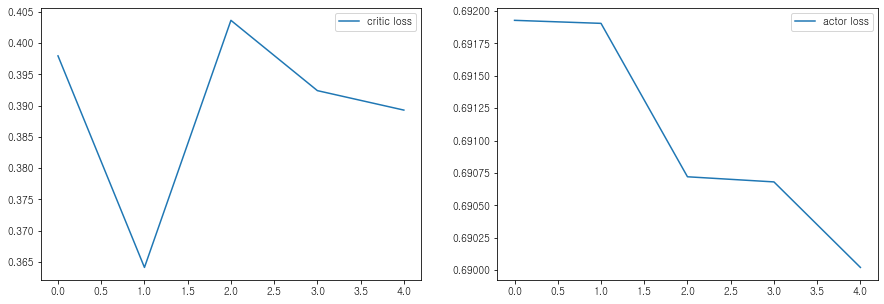

In [2]:
%%time
room_sync_list = ['솜사탕_거실.csv']
# room_sync_list = ['솜사탕_거실.csv', '솜사탕_거실.csv', '솜사탕_거실.csv', '솜사탕_거실.csv']
# room_sync_list = ['솜사탕_거실.csv', '솜사탕_방2.csv']

s = []
ns = []
a_list = []
r_list = []

start_date = '2022-01-04'
end_date = '2022-01-27'

len_list = []
for i in room_sync_list:
    temp_data = data_by_room[i].loc[start_date:end_date]
    len_notna = len(temp_data.dropna())
    len_list.append(len_notna)
max_na_room = room_sync_list[np.argmin(len_list)]
row_ind = data_by_room[max_na_room].loc[start_date:end_date].dropna().index




temp_data = data_by_room[i].loc[row_ind]

s.append(tf.convert_to_tensor(temp_data.values[:,[0,],],dtype=tf.float32))
ns.append(tf.convert_to_tensor(temp_data.values[:,[3,],],dtype=tf.float32))

a_list.append(tf.convert_to_tensor(temp_data.values[:,[8],],dtype=tf.int64))
a_list.append(tf.convert_to_tensor(temp_data.values[:,[9],],dtype=tf.int64))


r_list.append(tf.convert_to_tensor(temp_data.values[:,[6],],dtype=tf.float32))
r_list.append(tf.convert_to_tensor(temp_data.values[:,[7],],dtype=tf.float32))

print(temp_data.isna().sum())
#정규화 레이어
# layer = tf.keras.layers.Normalization(axis=1)
# layer.adapt(s[0])

#데이터셋 제작
# s_dataset = tf.data.Dataset.from_tensor_slices(layer(s[0]))
# ns_dataset = tf.data.Dataset.from_tensor_slices(layer(ns[0]))
s_dataset = tf.data.Dataset.from_tensor_slices(tf.keras.utils.normalize(s[0], axis=0, order=0))
ns_dataset = tf.data.Dataset.from_tensor_slices(tf.keras.utils.normalize(ns[0], axis=0, order=0))

a1_dataset = tf.data.Dataset.from_tensor_slices(a_list[0])
a2_dataset = tf.data.Dataset.from_tensor_slices(a_list[1])

r1_dataset = tf.data.Dataset.from_tensor_slices(r_list[0])
r2_dataset = tf.data.Dataset.from_tensor_slices(r_list[1])

done_dataset = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(data_by_room[i].loc[start_date:end_date].values[:,[10]],dtype=tf.float32))

train_dataset = tf.data.Dataset.zip((s_dataset, ns_dataset, ((a1_dataset,r1_dataset),(a2_dataset,r2_dataset),),done_dataset))
# train_dataset.element_spec

#################set params!################
# params of multi_AWAC
agent_num = 2
state_len = 1
hidden_structure= [64, 128, 256, 128, 64]
input_shape= 1
output_shape= 2
act_function= 'relu'
lam = 1
optimizer= keras.optimizers.Adam(learning_rate=3 * 1e-5)
gamma= 0.9
tau = 0.1
num_action_samples = 8
loss_fun = tf.keras.losses.MeanSquaredError()

# 학습 루프 관련
batch_size = 124
buffer_len = len(train_dataset)
# n_train = 10
n_run = 5
############################################
# 초기 모델 생성
actor_list, critic_qnet_list, critic_qnet_target_list = build_structure(agent_num, hidden_structure,input_shape,act_function,output_shape)


# #배치셋 생성
# batched_dataset = train_dataset.shuffle(buffer_size=buffer_len).batch(batch_size, drop_remainder=True)
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

# 트레인 루프
# for batch in batched_dataset.take(n_train):
critic_loss = []
actor_loss = []

actor = actor_list[0]
critic_qnet = critic_qnet_list[0]
critic_qnet_target = critic_qnet_target_list[0]





count = 0
for batch in shuffled_dataset.batch(batch_size).take(1).repeat(n_run):
    count += 1
    if count % 1 == 0:
        print(f"-run- [{count}]/[{n_run}]")
    
    with tf.GradientTape() as t:
        ##데이터 
        s = batch[0]
        ns = batch[1]
        a = batch[2][0][0]
        r = batch[2][0][1]
        done = batch[3]
        
        ##로스 계산
        qs = critic_qnet_target(ns)
        sampled_as = get_action(actor,ns, num_action_samples)
        mean_qsa = get_mean_qsa(qs,sampled_as)
        q_target = r + gamma * mean_qsa * (1 - done)

        # 식 3에서 봤던 것처럼 mse형태로 로스함수 설정
        q_val = tf.concat([tf.reshape(tf.gather(critic_qnet(s)[k],a[k],axis=0),[-1,1]) for k in range(len(s))],axis=0)
        loss = loss_fun(q_val, q_target)

    critic_loss.append(loss)    
    grads = t.gradient(loss, critic_qnet.trainable_variables)

    for q in range(1):
        # qnet 업데이트
        # qnet_weights = critic_qnet_weight_list[q]
        # qnet_target_weights = critic_qnet_target_weight_list[q]
        # grad = grads[q]
        optimizer.apply_gradients(zip(grads, critic_qnet.trainable_variables))
        # target net 업데이트
        new_target_weights = []
        for p, target_weights in enumerate(critic_qnet_target.trainable_variables):
            qnet_weights_s = critic_qnet.trainable_variables[p]
            updated_target_weights_s = target_weights*(1 - tau) + qnet_weights_s*tau
            new_target_weights.append(updated_target_weights_s)
        critic_qnet_target.set_weights(new_target_weights)

        #타겟네트워크까지 업데이트한 후 actor net 업데이트
        with tf.GradientTape() as tp:
            # log_probability 계산
            logits = actor(s)
            m = tfp.distributions.Categorical(logits = logits)
            log_prob = tf.reshape(m.log_prob(a.numpy().squeeze()),[-1,1])

            #가중치항 계산
            qs = critic_qnet_target(s)
            action_probs = tf.nn.softmax(logits, axis=None, name=None)
            vs = tf.math.reduce_sum((qs * action_probs),axis=1, keepdims=True, name=None)
            qas = tf.concat([tf.reshape(tf.gather(qs[k],a[k],axis=0),[-1,1]) for k in range(len(s))],axis=0)
            adv = qas - vs
            weight_term = tf.math.exp((1/lam*adv), name=None)
            
            

            #loss
            loss = tf.math.reduce_mean(log_prob * weight_term*-1)
        actor_grad = tp.gradient(loss, actor.trainable_variables)
        actor_loss.append(loss)
        optimizer.apply_gradients(zip(actor_grad, actor.trainable_variables))


fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(critic_loss, label='critic loss')
axes[0].legend()
axes[1].plot(actor_loss, label='actor loss')
axes[1].legend()

* strategy 사용

In [36]:
############# 데이터셋 ################
room_sync_list = ['솜사탕_거실.csv']
# room_sync_list = ['솜사탕_거실.csv', '솜사탕_거실.csv', '솜사탕_거실.csv', '솜사탕_거실.csv']
# room_sync_list = ['솜사탕_거실.csv', '솜사탕_방2.csv']

s = []
ns = []
a_list = []
r_list = []

start_date = '2022-01-04'
end_date = '2022-01-27'

len_list = []
for i in room_sync_list:
    temp_data = data_by_room[i].loc[start_date:end_date]
    len_notna = len(temp_data.dropna())
    len_list.append(len_notna)
max_na_room = room_sync_list[np.argmin(len_list)]
row_ind = data_by_room[max_na_room].loc[start_date:end_date].dropna().index




temp_data = data_by_room[i].loc[row_ind]

s.append(tf.convert_to_tensor(temp_data.values[:,[0,],],dtype=tf.float32))
ns.append(tf.convert_to_tensor(temp_data.values[:,[3,],],dtype=tf.float32))

a_list.append(tf.convert_to_tensor(temp_data.values[:,[8],],dtype=tf.int64))
a_list.append(tf.convert_to_tensor(temp_data.values[:,[9],],dtype=tf.int64))


r_list.append(tf.convert_to_tensor(temp_data.values[:,[6],],dtype=tf.float32))
r_list.append(tf.convert_to_tensor(temp_data.values[:,[7],],dtype=tf.float32))

print(temp_data.isna().sum())
#정규화 레이어
# layer = tf.keras.layers.Normalization(axis=1)
# layer.adapt(s[0])

#데이터셋 제작
# s_dataset = tf.data.Dataset.from_tensor_slices(layer(s[0]))
# ns_dataset = tf.data.Dataset.from_tensor_slices(layer(ns[0]))
s_dataset = tf.data.Dataset.from_tensor_slices(tf.keras.utils.normalize(s[0], axis=0, order=0))
ns_dataset = tf.data.Dataset.from_tensor_slices(tf.keras.utils.normalize(ns[0], axis=0, order=0))

a1_dataset = tf.data.Dataset.from_tensor_slices(a_list[0])
a2_dataset = tf.data.Dataset.from_tensor_slices(a_list[1])

r1_dataset = tf.data.Dataset.from_tensor_slices(r_list[0])
r2_dataset = tf.data.Dataset.from_tensor_slices(r_list[1])

done_dataset = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(data_by_room[i].loc[start_date:end_date].values[:,[10]],dtype=tf.float32))

train_dataset = tf.data.Dataset.zip((s_dataset, ns_dataset,a1_dataset,r1_dataset ,done_dataset))

############################################
#################set params!################
# params of multi_AWAC
agent_num = 2
state_len = 1
hidden_structure= [64, 128, 256, 128, 64]
input_shape= 1
output_shape= 2
act_function= 'relu'
lam = 100
optimizer= keras.optimizers.Adam(learning_rate=3 * 1e-5)
gamma= 0.9
tau = 0.1
num_action_samples = 8
loss_fun = tf.keras.losses.MeanSquaredError()

# 학습 루프 관련
batch_size = 512
buffer_len = len(train_dataset)
# n_train = 10
n_run = 900
############################################
# model, optimizer, and checkpoint must be created under `strategy.scope`
# starategy 설정
use_gpu = True
strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# strategy 학습 파라미터 설정
BUFFER_SIZE = len(train_dataset)
BATCH_SIZE_PER_REPLICA = batch_size
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
EPOCHS = 10

# strategy 분산 데이터 설정
train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(path,checkpoint_dir, "ckpt")

###각종 scope 설정###
with strategy.scope():
  # Set reduction to `none` so we can do the reduction afterwards and divide by
  # global batch size.
  loss_object = tf.keras.losses.MeanSquaredError(
      reduction=tf.keras.losses.Reduction.NONE)
  def compute_critic_loss(labels, predictions):
    per_example_loss = loss_object(labels, predictions)
    return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  def compute_actor_loss(kld):
    per_example_loss = tf.reshape(kld,[1])
    return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

with strategy.scope():
  test_loss = tf.keras.metrics.Mean(name='test_loss')

  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='train_accuracy')
  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='test_accuracy')

with strategy.scope():
  actor_list, critic_qnet_list, critic_qnet_target_list = build_structure(agent_num, hidden_structure,input_shape,act_function,output_shape)


  optimizer = tf.keras.optimizers.Adam()
  critic_qnet = critic_qnet_list[0]
  critic_qnet_target = critic_qnet_target_list[0]
  actor = actor_list[0]

  critic_qnet_target.set_weights(critic_qnet.get_weights()) 


  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=[critic_qnet,critic_qnet_target,actor])


############################################
def train_critic_step(s,ns,a,r,done):
  with tf.GradientTape() as tape:
    ##로스 계산
    qs = critic_qnet_target(ns)
    sampled_as = get_action(actor,ns, num_action_samples)
    mean_qsa = get_mean_qsa(qs,sampled_as)
    q_target = r + gamma * mean_qsa * (1 - done)

    # 식 3에서 봤던 것처럼 mse형태로 로스함수 설정
    q_val = tf.concat([tf.reshape(tf.gather(critic_qnet(s)[k],a[k],axis=0),[-1,1]) for k in range(len(s))],axis=0)
    loss = compute_critic_loss(q_val, q_target)
  grads = tape.gradient(loss, critic_qnet.trainable_variables)
  optimizer.apply_gradients(zip(grads, critic_qnet.trainable_variables))
  
  # target net soft update
  soft_g = [(b-a)*tau for a,b in zip(critic_qnet_target.trainable_variables, critic_qnet.trainable_variables)]
  # soft_g = (np.array(critic_qnet.trainable_variables) - np.array(critic_qnet_target.trainable_variables))*tau
  
  optimizer.apply_gradients(zip(soft_g, critic_qnet_target.trainable_variables))
  print(loss)
  return loss

def train_actor_step(s,a,):
  with tf.GradientTape() as tp:
      
      # log_probability 계산
      logits = actor(s)
      m = tfp.distributions.Categorical(logits = logits)
      log_prob = tf.reshape(m.log_prob(tf.squeeze(a)),[-1,1])
      
      #가중치항 계산
      qs = critic_qnet_target(s)
      action_probs = tf.nn.softmax(logits, axis=None, name=None)
      vs = tf.math.reduce_sum((qs * action_probs),axis=1, keepdims=True, name=None)
      qas = tf.concat([tf.reshape(tf.gather(qs[k],a[k],axis=0),[-1,1]) for k in range(len(s))],axis=0)
      adv = qas - vs
      weight_term = tf.math.exp((1/lam*adv), name=None)
      
      #loss
      kld = tf.math.reduce_mean(log_prob * weight_term*-1)
      loss = compute_actor_loss(kld)
      
  actor_grad = tp.gradient(loss, actor.trainable_variables)
  optimizer.apply_gradients(zip(actor_grad, actor.trainable_variables))
  # train_accuracy.update_state(labels, predictions)
  print(loss)
  return loss


@tf.function
def critic_distributed_train_step(s,ns,a,r,done):
  per_replica_losses = strategy.run(train_critic_step, args=(s,ns,a,r,done,))
  # tf.keras.losses.Reduction.SUM, tf.distribute.ReduceOp.SUM
  return strategy.reduce(tf.keras.losses.Reduction.SUM, per_replica_losses,
                         axis=None)

@tf.function
def actor_distributed_train_step(s,a,):
  per_replica_losses = strategy.run(train_actor_step, args=(s,a,))
  print('okkokokokokokokokokokokokokoko')
  # tf.keras.losses.Reduction.SUM, tf.distribute.ReduceOp.SUM
  return strategy.reduce(tf.keras.losses.Reduction.SUM, per_replica_losses,
                         axis=None)

co2            0
temp           0
people         0
co2_t+1        0
temp_t+1       0
people_t+1     0
reward_co2     0
reward_heat    0
vent           0
heat           0
done           0
dtype: int64
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Number of devices: 1


In [ ]:
for epoch in range(EPOCHS):
  # TRAIN LOOP
  critic_total_loss = 0.0
  actor_total_loss = 0.0
  num_batches = 0
  for x in train_dist_dataset:
  
    critic_total_loss += critic_distributed_train_step(x[0],x[1],x[2],x[3],x[4])
    actor_total_loss += actor_distributed_train_step(x[0],x[2])
    num_batches += 1
    
  critic_train_loss = critic_total_loss / num_batches
  actor_train_loss = actor_total_loss / num_batches

  

  if epoch % 2 == 0:
    checkpoint.save(checkpoint_prefix)

  template = ("Epoch {}, Critic Loss: {}, Actor Loss: {}, ")
  print (template.format(epoch+1, critic_train_loss,actor_train_loss))

  train_accuracy.reset_states()